### Setup inicial e preparação dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('OK')

years = ['2009', '2019']

def create_paths_for_many_years(years, file_base_name):
    paths = dict()
    for year in years:
        paths[year] = '{}/dados/{}.CSV'.format(year, file_base_name)
    return paths
    
def read_datasets_for_many_years(years, paths):
    dfs = dict()
    for year in years:
        dfs[year] = pd.read_csv(filepath_or_buffer=paths[year], sep='|', engine='python', encoding=encoding)
    return dfs

teacher_paths = create_paths_for_many_years(years, 'SUP_DOCENTE')   

encoding='ISO-8859-1'

def get_federals(df):
    public  = df[df["TP_CATEGORIA_ADMINISTRATIVA"].isin([1])]
    return public

teachers = read_datasets_for_many_years(years, teacher_paths)
columns = ['CO_CATEGORIA_ADMINISTRATIVA', 'CO_SITUACAO_DOCENTE', 'CO_ESCOLARIDADE_DOCENTE', 'IN_SEXO_DOCENTE', 'CO_COR_RACA_DOCENTE', 'IN_DOCENTE_DEFICIENCIA', 'IN_BOLSA_PESQUISA']
teachers['2009'] = teachers['2009'][columns]

### 2009 adjusts
columns = {
    'CO_CATEGORIA_ADMINISTRATIVA': 'TP_CATEGORIA_ADMINISTRATIVA', 
    'CO_SITUACAO_DOCENTE': 'TP_SITUACAO',
    'CO_ESCOLARIDADE_DOCENTE': 'TP_ESCOLARIDADE',
    'IN_SEXO_DOCENTE': 'TP_SEXO',
    'CO_COR_RACA_DOCENTE': 'TP_COR_RACA',
    'IN_DOCENTE_DEFICIENCIA': 'IN_DEFICIENCIA'
}
teachers['2009'].rename(columns=columns, inplace=True)
teachers['2009']['NU_ANO_CENSO'] = pd.Series([2009 for x in range(len(teachers['2009'].index))])

teachers['2009']['TP_CATEGORIA_ADMINISTRATIVA'] = teachers['2009']['TP_CATEGORIA_ADMINISTRATIVA'].replace({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada', 5: 'Privada', 6: 'Privada'})
teachers['2009']['TP_SEXO'] = teachers['2009']['TP_SEXO'].replace({0: 'Masculino', 1: 'Feminino'})

teachers['2009'].head()

### 2019 adjusts
columns = ['NU_ANO_CENSO', 'TP_CATEGORIA_ADMINISTRATIVA', 'TP_SITUACAO', 'TP_ESCOLARIDADE', 'TP_SEXO', 'TP_COR_RACA', 'IN_DEFICIENCIA', 'IN_BOLSA_PESQUISA']
teachers['2019'] = teachers['2019'][columns]
teachers['2019']['TP_CATEGORIA_ADMINISTRATIVA'] = teachers['2019']['TP_CATEGORIA_ADMINISTRATIVA'].replace({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada', 5: 'Privada', 6: 'Privada', 7: 'Especial', 8: 'Privada', 9: 'Privada'})
teachers['2019']['TP_SEXO'] = teachers['2019']['TP_SEXO'].replace({1: 'Feminino', 2: 'Masculino'})

### multiple adjusts
df = pd.concat([teachers['2009'], teachers['2019']])
df['TP_SITUACAO'] = df['TP_SITUACAO'].replace({1: 'Em exercício', 2: 'Afastado para qualificação', 3: 'Afastado por outros motivos', 4: 'Afastado por outros motivos', 5: 'Afastado por outros motivos', 6: 'Falecido'})
df['TP_ESCOLARIDADE'] = df['TP_ESCOLARIDADE'].replace({1: 'Sem graduação', 2: 'Graduação', 3: 'Especialização', 4: 'Mestrado', 5: 'Doutorado'})
df['TP_COR_RACA'] = df['TP_COR_RACA'].replace({0: 'Não quis declarar', 1: 'Branca', 2: 'Preta', 3: 'Parda', 4: 'Amarela', 5: 'Indígena', 6: 'Não dispõe da informação', 9: 'Não dispõe da informação'})
df['IN_DEFICIENCIA'] = df['IN_DEFICIENCIA'].replace({0: False, 1: True, 9: None})
df['IN_BOLSA_PESQUISA'] = df['IN_BOLSA_PESQUISA'].replace({0: False, 1: True})

df.rename(columns={'TP_CATEGORIA_ADMINISTRATIVA': 'Categoria Administrativa', 'TP_SITUACAO': 'Situação', 'TP_ESCOLARIDADE': 'Escolaridade', 'TP_SEXO': 'Sexo', 'TP_COR_RACA': 'Raça', 'NU_ANO_CENSO': 'Ano', 'IN_DEFICIENCIA': 'Deficiência', 'IN_BOLSA_PESQUISA': 'Bolsa Pesquisa'}, inplace=True)

def get_total_by_year_by_reference(total_by_year, total_references, x):
    if len(total_references) <= 0:
        return total_by_year[x['Ano']]
    else:
        return total_by_year[tuple(x[col] for col in (['Ano']+total_references))]

def create_table_by_segregators(input_df, segregators, total_references = []):
    count_by_segregators_and_year = input_df.groupby(['Ano'] + segregators).size().reset_index(name='Quantidade')
    total_by_year = count_by_segregators_and_year.groupby(['Ano'] + total_references)['Quantidade'].sum()
    count_by_segregators_and_year['Porcentagem'] = count_by_segregators_and_year.apply(lambda x: (x['Quantidade'] / get_total_by_year_by_reference(total_by_year, total_references, x) * 100).round(2), axis=1)

    percentage_pivot = count_by_segregators_and_year.pivot(index=segregators, columns='Ano', values='Porcentagem')
    quantity_pivot  = count_by_segregators_and_year.pivot(index=segregators, columns='Ano', values='Quantidade')
    entities_by_segregators = pd.concat([quantity_pivot, percentage_pivot], axis=1)

    columns_tuples = [
        ('Quantidade', entities_by_segregators.columns[0]),
        ('Quantidade', entities_by_segregators.columns[1]),
        ('Porcentagem', entities_by_segregators.columns[2]),
        ('Porcentagem', entities_by_segregators.columns[3])
    ]
    columns = pd.MultiIndex.from_tuples(columns_tuples)
    entities_by_segregators.columns = columns

    quantity_evolution = entities_by_segregators['Quantidade', 2019] - entities_by_segregators['Quantidade', 2009]
    percentage_evolution = entities_by_segregators['Porcentagem', 2019] - entities_by_segregators['Porcentagem', 2009]
    
    percentage_increase = ((percentage_evolution/entities_by_segregators['Porcentagem', 2009]) * 100).round(2)

    entities_by_segregators[('Quantidade', 'Evolução')] = quantity_evolution
    entities_by_segregators[('Porcentagem', 'Evolução (%)')] = percentage_evolution
    entities_by_segregators[('Porcentagem', 'Aumento Percentual (%)')] = percentage_increase

    new_columns_order = [
        ('Quantidade', 2009),
        ('Quantidade', 2019),
        ('Quantidade', 'Evolução'),
        ('Porcentagem', 2009),
        ('Porcentagem', 2019),
        ('Porcentagem', 'Evolução (%)'),
        ('Porcentagem', 'Aumento Percentual (%)')
    ]

    entities_by_segregators = entities_by_segregators[new_columns_order]
    entities_by_segregators.index.name = segregators[0]

    reseted_entities_by_segregators = entities_by_segregators.reset_index()

    segregators_dict = dict()
    for segregator in segregators:
        segregators_dict[segregator] = reseted_entities_by_segregators[segregator]

    segregators_dict[2009] = reseted_entities_by_segregators[('Porcentagem', 2009)]
    segregators_dict[2019] = reseted_entities_by_segregators[('Porcentagem', 2019)]
    segregators_dict['Evolução (%)'] = reseted_entities_by_segregators[('Porcentagem', 'Evolução (%)')]
    segregators_dict['Aumento Percentual (%)'] = reseted_entities_by_segregators[('Porcentagem', 'Aumento Percentual (%)')]

    entities_evolution_by_segregators = pd.DataFrame(segregators_dict)

    return entities_by_segregators, entities_evolution_by_segregators, count_by_segregators_and_year


OK


In [2]:
def plot_slope_graph(x, y, hue, data, figsize = (5, 5), size = 10, **kwargs):
    ax = kwargs.get('ax', None)
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    
    graph = sns.lineplot(x=x, y=y, hue=hue, marker='o', linewidth=2, data=data, **kwargs)
    graph.set_xticks([2009, 2019])
    #ax.set_title("Relação entre total da conta e gorjeta")

    for line, name in zip(graph.lines, data[hue].unique()):
        if len(line.get_ydata()):
            y_initial = line.get_ydata()[0]
            y_final = line.get_ydata()[-1]

            # Adicionar valor inicial
            graph.annotate(f'{y_initial:.2f}%',
                           xy=(0, y_initial),
                           xytext=(-37, 0),
                           color=line.get_color(),
                           xycoords=graph.get_yaxis_transform(),
                           textcoords="offset points",
                           size=size,
                           va="center")

            # Adicionar valor final
            graph.annotate(f'{y_final:.2f}%     {name}',
                           xy=(1, y_final),
                           xytext=(0, 0),
                           color=line.get_color(),
                           xycoords=graph.get_yaxis_transform(),
                           textcoords="offset points",
                           size=size,
                           va="center")   


    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    graph.legend_ = None
      
        
def plot_comparison_graph(count_by_segregator_and_year_df, segregator, spacing = 0.5, label_rotation = 0, horizontalalignment = 'center', **kwargs):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    plt.subplots_adjust(wspace=spacing, hspace=spacing)
    
    graphs = []

    graphs.append(sns.barplot(x=segregator, y="Quantidade", hue="Ano", data=count_by_segregator_and_year_df, ax=axs[0, 0], **kwargs))
    graphs.append(sns.barplot(x=segregator, y="Porcentagem", hue="Ano", data=count_by_segregator_and_year_df, ax=axs[0,1], **kwargs))

    graphs.append(sns.lineplot(x="Ano", y="Quantidade", hue=segregator, marker='o', data=count_by_segregator_and_year_df, ax=axs[1,0]))
    graphs.append(sns.lineplot(x="Ano", y="Porcentagem", hue=segregator, marker='o', data=count_by_segregator_and_year_df, ax=axs[1,1]))

    for graph in graphs[2:4]:
        graph.set_xticks([2009, 2019])

    for graph in graphs:
        graph.set_xticklabels(graph.get_xticklabels(), rotation=label_rotation, horizontalalignment=horizontalalignment)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    return count_by_segregator_and_year_df


def plot_evolution_graph(entities_evolution_by_segregator, segregator, spacing = 0.5, label_rotation = 0, horizontalalignment = 'center', **kwargs):
    fig, axs = plt.subplots(figsize=(4, 3))
    graph = sns.barplot(x=segregator, y='Aumento Percentual (%)', data=entities_evolution_by_segregator, **kwargs)
    graph.set_xticklabels(graph.get_xticklabels(), rotation=label_rotation, horizontalalignment=horizontalalignment)
    plt.tight_layout()

### a

In [3]:
original_df = df
original_df.shape
original_df.head(8)

isnulldf = original_df[original_df['Deficiência'].isnull()]
contagem = isnulldf['Ano'].value_counts()

contagem
original_df.isna().sum()

Categoria Administrativa         0
Situação                         0
Escolaridade                     0
Sexo                             0
Raça                             0
Deficiência                  43376
Bolsa Pesquisa              287856
Ano                              0
dtype: int64

In [4]:
df = original_df[(original_df['Situação'] == 'Em exercício') & (original_df['Raça'] != 'Não dispõe da informação') & (original_df['Raça'] != 'Não quis declarar') & (original_df['Categoria Administrativa'] != 'Especial')]
public_values = ['Estadual', 'Municipal', 'Federal']
df.shape

(477647, 8)

In [5]:
cond1_counts = original_df[original_df['Situação'] != 'Em exercício'].groupby('Ano').size()
cond2_counts = original_df[original_df['Raça'] == 'Não dispõe da informação'].groupby('Ano').size()
cond3_counts = original_df[original_df['Raça'] == 'Não quis declarar'].groupby('Ano').size()
cond4_counts = original_df[original_df['Categoria Administrativa'] == 'Especial'].groupby('Ano').size()

# Crie um DataFrame com os resultados no formato solicitado
counts_2009_2019 = pd.DataFrame({
    'Ano': [2009, 2019],
    'Situação != Em exercício': [cond1_counts.get(2009, 0), cond1_counts.get(2019, 0)],
    'Raça = Não dispõe da informação': [cond2_counts.get(2009, 0), cond2_counts.get(2019, 0)],
    'Raça = Não quis declarar': [cond3_counts.get(2009, 0), cond3_counts.get(2019, 0)],
    'Categoria Administrativa = Especial': [cond4_counts.get(2009, 0), cond4_counts.get(2019, 0)]
}).set_index('Ano').transpose()

counts_2009_2019

Ano,2009,2019
Situação != Em exercício,18272,13355
Raça = Não dispõe da informação,64217,0
Raça = Não quis declarar,78466,118232
Categoria Administrativa = Especial,0,1893


In [6]:
quantity_2009 = len(original_df[original_df['Ano'] == 2009])
quantity_2019 = len(original_df[original_df['Ano'] == 2019])

analysis_universe_2009 = len(df[df['Ano'] == 2009])
analysis_universe_2019 = len(df[df['Ano'] == 2019])

diresgarded_2009 = quantity_2009 - analysis_universe_2009
diresgarded_2019 = quantity_2019 - analysis_universe_2019

total = quantity_2009 + quantity_2019

original_quantities = pd.DataFrame({
    'Ano': [2009, 2019],
    'Quantidade': [quantity_2009, quantity_2019],
    'Desconsiderados': [diresgarded_2009, diresgarded_2019],
    '%': [ (diresgarded_2009 / quantity_2009), ((diresgarded_2019/quantity_2019))],
    'Universo de análise': [analysis_universe_2009, analysis_universe_2019]
})

original_quantities

,Ano,Quantidade,Desconsiderados,%,Universo de análise
0,2009,359089,152892,0.425777,206197
1,2019,399428,127978,0.320403,271450


### Observações gerais sobre a base

In [7]:
df['Pública'] = df['Categoria Administrativa'].isin(public_values)

# Usando a função groupby() para agrupar os dados por ano e categoria administrativa
count = df.groupby(['Ano', 'Categoria Administrativa']).size()

# Usando a função unstack() para transformar os dados em formato de tabela
table = count.unstack('Categoria Administrativa', fill_value=0)

# Somando
table['Pública'] = table['Estadual'] + table['Municipal'] + table['Federal']
table['Total'] = table['Pública'] + table['Privada']

# Selecionando apenas as colunas desejadas
table = table[['Estadual', 'Municipal', 'Federal', 'Pública', 'Privada', 'Total']]

# Exibindo o resultado
table


C:\Users\thais\AppData\Local\Temp\ipykernel_18400\3093697293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pública'] = df['Categoria Administrativa'].isin(public_values)


Categoria Administrativa,Estadual,Municipal,Federal,Pública,Privada,Total
Ano,,,,,,
2009,21857,6401,27725,55983,150214,206197
2019,31672,4142,67800,103614,167836,271450


### Qual a presença de docentes por raça?

In [8]:
public_teachers_by_race, public_teachers_evolution_by_race, count_public_teachers_by_race_and_year = create_table_by_segregators(df[df['Pública'] == True], segregators=['Raça'])
public_teachers_evolution_by_race

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,1.89,1.98,0.09,4.76
1,Branca,80.29,72.28,-8.01,-9.98
2,Indígena,0.21,0.29,0.08,38.10
3,Parda,15.08,21.61,6.53,43.30
4,Preta,2.52,3.83,1.31,51.98


In [9]:
private_teachers_by_race, private_teachers_evolution_by_race, count_private_teachers_by_race_and_year = create_table_by_segregators(df[df['Categoria Administrativa'] == 'Privada'], segregators=['Raça'])
private_teachers_evolution_by_race

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,1.03,1.12,0.09,8.74
1,Branca,81.12,76.31,-4.81,-5.93
2,Indígena,0.22,0.11,-0.11,-50.00
3,Parda,15.88,20.19,4.31,27.14
4,Preta,1.76,2.27,0.51,28.98


In [10]:
federal_teachers_by_race, federal_teachers_evolution_by_race, count_federal_teachers_by_race_and_year = create_table_by_segregators(df[df['Categoria Administrativa'] == 'Federal'], segregators=['Raça'])
federal_teachers_evolution_by_race

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,1.53,1.88,0.35,22.88
1,Branca,78.03,69.74,-8.29,-10.62
2,Indígena,0.22,0.33,0.11,50.00
3,Parda,17.20,23.83,6.63,38.55
4,Preta,3.02,4.21,1.19,39.40


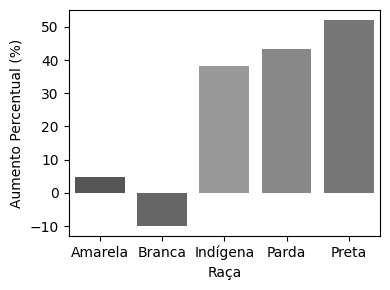

In [11]:
palette = {'Amarela': '#555', 'Branca': '#666', 'Preta': '#777', 'Parda': '#888', 'Indígena': '#999'} 
plot_evolution_graph(public_teachers_evolution_by_race, 'Raça', palette=palette)

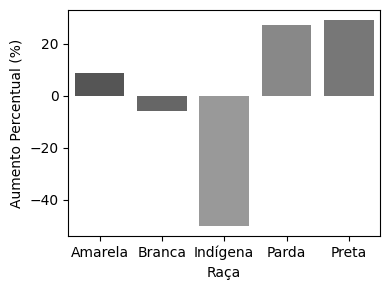

In [12]:
palette = {'Amarela': '#555', 'Branca': '#666', 'Preta': '#777', 'Parda': '#888', 'Indígena': '#999'} 
plot_evolution_graph(private_teachers_evolution_by_race, 'Raça', palette=palette)  

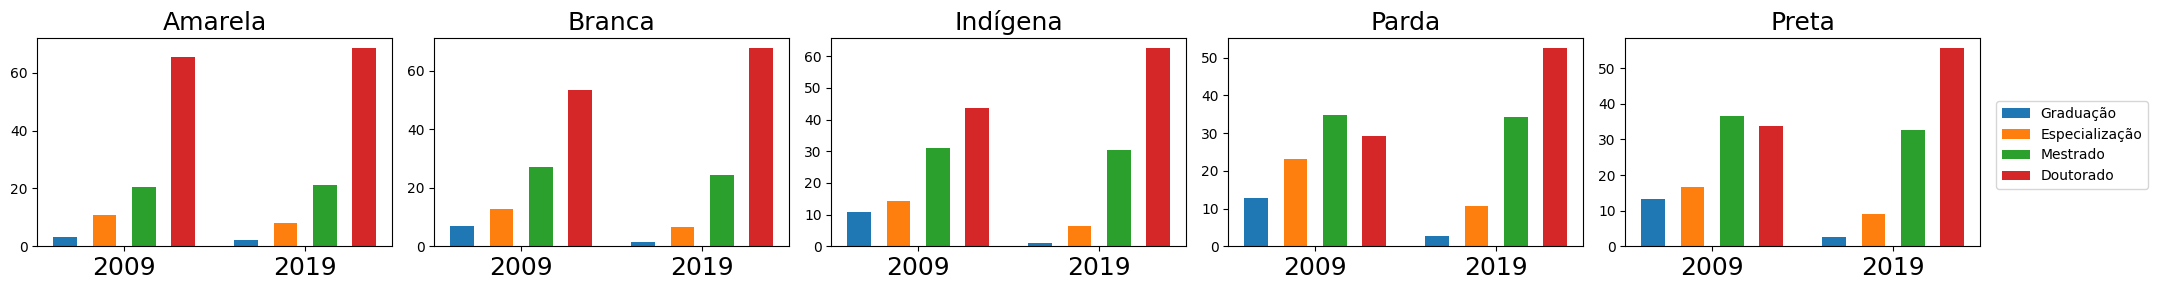

In [13]:
import numpy as np
# Lista das raças

def create_race_by_scolarship_graph(df):
    racas = ['Amarela', 'Branca', 'Indígena', 'Parda', 'Preta']

    # Cria a figura e os eixos (subplots)
    fig, axs = plt.subplots(1, len(racas), figsize=(20, 3))  # Altere aqui para (1, len(racas))

    # Largura das barras
    bar_width = 0.15

    # Função para criar as posições das barras para cada ano
    def get_bar_positions(n, bar_width, group_spacing, bar_spacing):
        positions = []
        for i in range(n):
            group_start = i * (group_spacing + bar_width)
            positions.append([group_start + j * (bar_width + bar_spacing) for j in range(4)])
        return np.array(positions)

    # Posição das barras no eixo X
    pos = get_bar_positions(2, bar_width, 1, 0.1)

    # Cores para as barras
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    # Ordem das escolaridades
    escolaridades = ['Graduação', 'Especialização', 'Mestrado', 'Doutorado']

    for i, raca in enumerate(racas):
        # Filtra o dataframe pela raça e pelos anos 2009 e 2019
        df_filtrado = df[(df['Raça'] == raca) & (df['Ano'].isin([2009, 2019]))]

        # Separa os dados por ano
        df_2009 = df_filtrado[df_filtrado['Ano'] == 2009]
        df_2019 = df_filtrado[df_filtrado['Ano'] == 2019]

        # Cria as barras para 2009 e 2019 na ordem desejada
        for j, escolaridade in enumerate(escolaridades):
            label = escolaridade if i == 0 else None
            if df_2009[df_2009['Escolaridade'] == escolaridade]['Porcentagem'].values.size > 0:
                axs[i].bar(pos[0, j], df_2009[df_2009['Escolaridade'] == escolaridade]['Porcentagem'].values[0], width=bar_width, color=colors[j], label=label)
            if df_2019[df_2019['Escolaridade'] == escolaridade]['Porcentagem'].values.size > 0:
                axs[i].bar(pos[1, j], df_2019[df_2019['Escolaridade'] == escolaridade]['Porcentagem'].values[0], width=bar_width, color=colors[j])

        # Define os rótulos do eixo X e o título do gráfico
        axs[i].set_xticks(pos.mean(axis=1))
        axs[i].set_xticklabels(['2009', '2019'], fontsize=18)
        axs[i].set_title(f'{raca}', fontsize=18)

    # Adiciona a legenda fora do gráfico à direita de todos os gráficos
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.08, 0.5))

    # Ajusta o layout para evitar sobreposição de elementos
    fig.tight_layout()

    # Exibe o gráfico
    plt.show()

_, _, count_public_by_race_and_scolarship_and_year  = create_table_by_segregators(df[(df['Escolaridade'] != 'Sem graduação') & (df['Pública'] == True)], segregators=['Raça', 'Escolaridade'], total_references=['Raça'])
_, _, count_private_by_race_and_scolarship_and_year = create_table_by_segregators(df[(df['Escolaridade'] != 'Sem graduação') & (df['Pública'] == False)], segregators=['Raça', 'Escolaridade'], total_references=['Raça'])
_, _, count_federals_by_race_and_scolarship_and_year = create_table_by_segregators(df[(df['Escolaridade'] != 'Sem graduação') & (df['Categoria Administrativa'] == 'Federal')], segregators=['Raça', 'Escolaridade'], total_references=['Raça'])
create_race_by_scolarship_graph(count_public_by_race_and_scolarship_and_year)

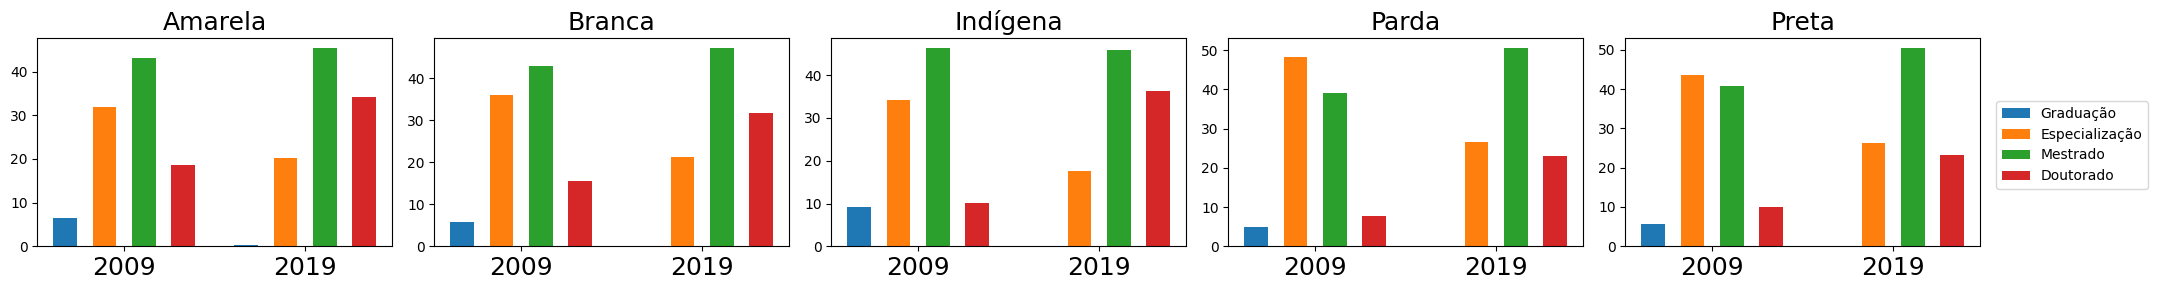

In [14]:
create_race_by_scolarship_graph(count_private_by_race_and_scolarship_and_year)

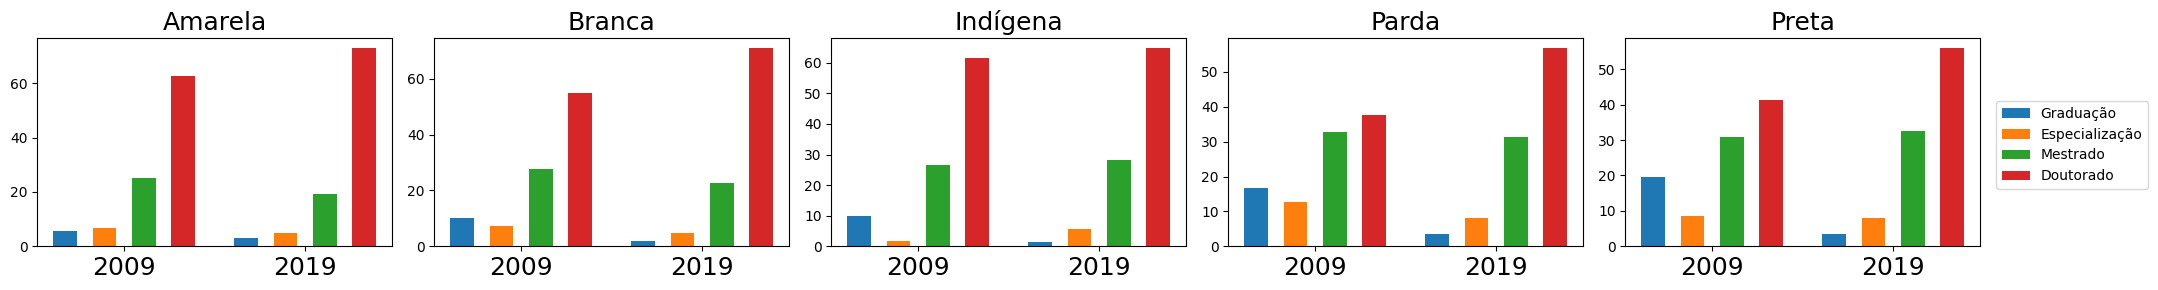

In [15]:
create_race_by_scolarship_graph(count_federals_by_race_and_scolarship_and_year)

## Qual a presença de docentes com bolsa de pesquisa?

In [16]:
teachers_by_research_grant, teachers_evolution_by_research_grant, count_by_research_grant_and_year = create_table_by_segregators(df[(df['Bolsa Pesquisa'] == True) & (df['Pública'] == True)], segregators=['Raça'])
#plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", figsize=(4, 4), size=10, data=count_by_research_grant_and_year)
teachers_evolution_by_research_grant

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,3.23,2.00,-1.23,-38.08
1,Branca,88.59,80.36,-8.23,-9.29
2,Indígena,0.14,0.15,0.01,7.14
3,Parda,6.51,14.36,7.85,120.58
4,Preta,1.52,3.12,1.60,105.26


In [17]:
teachers_by_research_grant, teachers_evolution_by_research_grant, count_by_research_grant_and_year = create_table_by_segregators(df[(df['Bolsa Pesquisa'] == True) & (df['Categoria Administrativa'] == 'Privada')], segregators=['Raça'])
#plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", figsize=(4, 4), size=10, data=count_by_research_grant_and_year)
teachers_evolution_by_research_grant

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,1.01,1.14,0.13,12.87
1,Branca,87.40,82.81,-4.59,-5.25
2,Indígena,0.07,0.16,0.09,128.57
3,Parda,10.17,13.99,3.82,37.56
4,Preta,1.35,1.89,0.54,40.00


In [18]:
teachers_by_research_grant, teachers_evolution_by_research_grant, count_by_research_grant_and_year = create_table_by_segregators(df[(df['Bolsa Pesquisa'] == True) & (df['Categoria Administrativa'] == 'Federal')], segregators=['Raça'])
#plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", figsize=(4, 4), size=10, data=count_by_research_grant_and_year)
teachers_evolution_by_research_grant

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,3.00,1.96,-1.04,-34.67
1,Branca,83.78,72.58,-11.20,-13.37
2,Indígena,0.29,0.21,-0.08,-27.59
3,Parda,10.69,22.23,11.54,107.95
4,Preta,2.23,3.02,0.79,35.43


## Qual a presença de docentes deficientes?

In [19]:
teachers_by_deficiency, teachers_evolution_by_deficiency, count_by_deficiency_and_year = create_table_by_segregators(df[(df['Deficiência'] == True) & (df['Pública'] == True)], segregators=['Raça'])
#plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", figsize=(4, 4), size=10, data=count_by_research_grant_and_year)
teachers_evolution_by_deficiency

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,3.26,3.01,-0.25,-7.67
1,Branca,77.67,69.94,-7.73,-9.95
2,Indígena,0.93,1.20,0.27,29.03
3,Parda,15.35,20.44,5.09,33.16
4,Preta,2.79,5.41,2.62,93.91


In [20]:
teachers_by_deficiency, teachers_evolution_by_deficiency, count_by_deficiency_and_year = create_table_by_segregators(df[(df['Deficiência'] == True) & (df['Categoria Administrativa'] == 'Privada')], segregators=['Raça'])
#plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", figsize=(4, 4), size=10, data=count_by_research_grant_and_year)
teachers_evolution_by_deficiency

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,1.41,1.08,-0.33,-23.40
1,Branca,82.19,80.97,-1.22,-1.48
2,Indígena,0.18,NaN,NaN,NaN
3,Parda,15.17,15.24,0.07,0.46
4,Preta,1.06,2.70,1.64,154.72


In [21]:
teachers_by_deficiency, teachers_evolution_by_deficiency, count_by_deficiency_and_year = create_table_by_segregators(df[(df['Deficiência'] == True) & (df['Categoria Administrativa'] == 'Federal')], segregators=['Raça'])
#plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", figsize=(4, 4), size=10, data=count_by_research_grant_and_year)
teachers_evolution_by_deficiency

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,3.38,2.61,-0.77,-22.78
1,Branca,81.76,69.03,-12.73,-15.57
2,Indígena,0.68,1.87,1.19,175.00
3,Parda,11.49,19.78,8.29,72.15
4,Preta,2.70,6.72,4.02,148.89


In [22]:
print(len(df[(df['Deficiência'] == True) & (df['Ano'] == 2009)]))
print(len(df[(df['Deficiência'] == True) & (df['Ano'] == 2019)]))

print(len(df[(df['Deficiência'] == True) & (df['Ano'] == 2009) & (df['Raça'] == 'Indígena') & (df['Categoria Administrativa'] == 'Privada')]))
print(len(df[(df['Deficiência'] == True) & (df['Ano'] == 2019) & (df['Raça'] == 'Indígena') & (df['Categoria Administrativa'] == 'Privada')]))


782
1424
1
0
